Problem Overview
The goal is to build a recommendation system that predicts the likelihood of a user liking a specific movie, based on their past ratings. The system uses the Movielens dataset (small version), which contains:

Ratings.csv: User ratings for movies.
Movies.csv: Details of the movies.

In [1]:
# !pip install keras tensorflow

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile

import keras
from keras import layers
from keras import ops

2024-12-08 11:21:39.868143: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-08 11:21:39.870718: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-08 11:21:39.877858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733638899.889933   97175 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733638899.893273   97175 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 11:21:39.906457: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Load the data and apply preprocessing

Downloading the Data: The dataset is fetched from the MovieLens website, which provides user-movie ratings.

Unzipping the Data: The dataset is extracted if it hasn’t been already.

Encoding Users and Movies:
Users and movies are mapped to unique integer indices for embedding purposes

Mappings (user2user_encoded, movie2movie_encoded) allow conversion between original IDs and encoded values.

Dataset Statistics:
Number of users, movies, and the range of ratings are calculated

Normalization:
Ratings are normalized between 0 and 1.

In [3]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

In [4]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


# Prepare training and validation data

The dataset is shuffled and split into training (90%) and validation (10%) sets.

Input (x) consists of user and movie IDs.

Target (y) consists of normalized ratings

In [5]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

# Model

We embed both users and movies in to 50-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias. The match score is scaled to the [0, 1] interval via a sigmoid (since our ratings are normalized to this range).



## Embedding Layers

User Embedding: Each user is assigned a vector of size EMBEDDING_SIZE (e.g., 50 dimensions).

Movie Embedding: Each movie is similarly mapped to a vector of size EMBEDDING_SIZE.

These embeddings allow the model to learn the underlying patterns in user-movie interactions.

## Bias Layers

Each user and movie have an associated scalar bias, capturing individual tendencies:
Users might rate movies higher or lower in general.
Some movies may generally receive higher ratings than others.

## Dot Product

The similarity between user and movie embeddings is calculated via a dot product:

score=u⋅v+b u+b m

where:

u: User embedding vector

v: Movie embedding vector.

bu, bm: User and movie biases.

## Sigmoid Activation

The dot product result is passed through a sigmoid function to scale it to [0, 1]:

σ(x)= 1/1+e-x



In [6]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = ops.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return ops.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

W0000 00:00:1733638901.424001   97175 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Embedding: Creates trainable embeddings for users and movies.

Regularization: Helps prevent overfitting by penalizing overly large weights.

Forward

Input: A pair (user_id, movie_id).

Output: Predicted rating in [0, 1].

# Training

Loss Function
The model minimizes the Binary Crossentropy loss, comparing predicted ratings with true rating

This works well as the ratings are normalized to the [0, 1] range.

Optimizer
The Adam optimizer adjusts weights dynamically during training

Learning rate (𝜂) is set to 0.001 for stable convergence.

In [7]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6572 - val_loss: 0.6205
Epoch 2/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6155 - val_loss: 0.6188
Epoch 3/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6096 - val_loss: 0.6163
Epoch 4/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6087 - val_loss: 0.6160
Epoch 5/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6073 - val_loss: 0.6130


Batch size: 64 samples are used per step.

Epochs: 5 iterations over the entire training dataset.

Validation data: Used to monitor model performance on unseen data.

# Plot training and validation loss

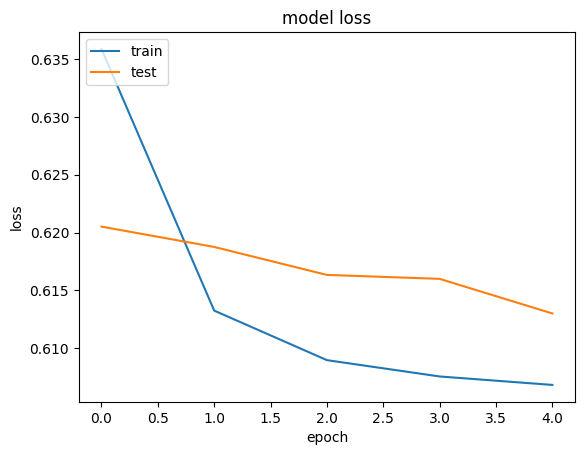

In [8]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# Show top 10 movie recommendations to a user

After training, the model generates recommendations by:

Encoding user and movie IDs.

Predicting ratings for unseen movies.

Sorting and selecting the top N movies based on predicted ratings

In [11]:
from math import sqrt
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score

movie_df = pd.read_csv(movielens_dir / "movies.csv")


# ==========================
# Compute additional metrics
# ==========================
# Get predictions on the validation set
y_val_pred = model.predict(x_val).flatten()

# Convert normalized predictions back to original rating scale
y_val_pred_rescaled = y_val_pred * (max_rating - min_rating) + min_rating
y_val_rescaled = y_val * (max_rating - min_rating) + min_rating

# RMSE
rmse = sqrt(mean_squared_error(y_val_rescaled, y_val_pred_rescaled))
print("RMSE on validation set: {:.4f}".format(rmse))

# For precision, recall, f1, we need a binarized scenario.
# Let's define a threshold, for example:
# If rating >= 3.5, consider it a "positive" interaction.
threshold = 3.5
y_val_true_binary = (y_val_rescaled >= threshold).astype(int)
y_val_pred_binary = (y_val_pred_rescaled >= threshold).astype(int)

precision = precision_score(y_val_true_binary, y_val_pred_binary, zero_division=0)
recall = recall_score(y_val_true_binary, y_val_pred_binary, zero_division=0)
f1 = f1_score(y_val_true_binary, y_val_pred_binary, zero_division=0)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

# Hit Ratio:
# For simplicity, we'll define "hit ratio" as follows:
# 1) For each user in the validation set, identify one "positive" item (rated >= threshold)
# 2) Generate top-N predictions for that user.
# 3) Check if the positive item is in the top-N predicted items.
# Note: This is a rough illustration. Typically, you'd hold out a set of items and see if
# they appear in the top-N recommended list for the user.

N = 10
val_users = x_val[:, 0]
val_movies = x_val[:, 1]

# Group by user and find at least one positive ground-truth item
user_positive_items = {}
for i, user in enumerate(val_users):
    if y_val_true_binary[i] == 1:
        if user not in user_positive_items:
            user_positive_items[user] = []
        user_positive_items[user].append(val_movies[i])

# Compute top-N recommendations for each user
hit_count = 0
total_users = 0

for user, positives in user_positive_items.items():
    # Get all movie IDs not watched by this user from full dataset
    # This requires user history:
    user_history = df[df['user'] == user]['movie'].unique()

    # We'll consider all movies not in user's history as candidates
    candidate_movies = [m for m in range(num_movies) if m not in user_history]

    user_array = np.array([user] * len(candidate_movies))
    candidates = np.vstack((user_array, candidate_movies)).T
    candidate_preds = model.predict(candidates).flatten()

    # Get top-N recommendations
    top_n_indices = np.argsort(candidate_preds)[-N:]
    top_n_movies = [candidate_movies[idx] for idx in top_n_indices]

    # Check if any of the positive items is in top-N
    # If yes, that's a hit.
    if any(pos_item in top_n_movies for pos_item in positives):
        hit_count += 1
    total_users += 1

hit_ratio = hit_count / total_users if total_users > 0 else 0.0
print("Hit Ratio @{}: {:.4f}".format(N, hit_ratio))

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step
RMSE on validation set: 0.9684
Precision: 0.8517
Recall: 0.3820
F1 Score: 0.5274
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
293/293 ━━━━━━━━